In [1]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import torchvision
from fastai.callbacks import *
from scipy import ndimage
import pickle

import numpy as np
import pandas as pd
import os
from imageio import imread
from scipy.io import loadmat
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
markerData = pd.read_csv('markerData.csv',sep="|",header=None)

markerData.columns = ['filename','markers','lastPoint','vertMidPoint','imageWidth']

markerData = markerData.drop_duplicates()

In [3]:
markerData.head()

,filename,markers,lastPoint,vertMidPoint,imageWidth
0,75181645_R_CC_1,"[0.0, 378.0, 756.0, 1133.0, 1511.0]",1512,2176,3328
1,75865422_L_CC_1,"[375.0, 1113.0, 1851.0, 2589.0, 3327.0]",375,1832,3328
2,4980043_R_CC_1,"[0.0, 625.0, 1250.0, 1874.0, 2499.0]",2500,2012,3328
3,4285649_L_CC_1,"[1663.0, 2079.0, 2495.0, 2911.0, 3327.0]",1663,1948,3328
4,76441079_L_CC_1,"[771.0, 1218.0, 1665.0, 2112.0, 2559.0]",771,1512,2560


## Generating Output

In [4]:
markerData['patientID'] = markerData.filename.apply(lambda x : x.split("_")[0])
markerData['side'] = markerData.filename.apply(lambda x : x.split("_")[1])

markerData['marker1'] = markerData.markers.apply(lambda x : float(x.split(",")[0].replace('[','')))
markerData['marker2'] = markerData.markers.apply(lambda x : float(x.split(",")[1]))
markerData['marker3'] = markerData.markers.apply(lambda x : float(x.split(",")[2]))
markerData['marker4'] = markerData.markers.apply(lambda x : float(x.split(",")[3]))
markerData['marker5'] = markerData.markers.apply(lambda x : float(x.split(",")[4].replace(']','')))

In [5]:
markerData.head()

,filename,markers,lastPoint,vertMidPoint,imageWidth,patientID,side,marker1,marker2,marker3,marker4,marker5
0,75181645_R_CC_1,"[0.0, 378.0, 756.0, 1133.0, 1511.0]",1512,2176,3328,75181645,R,0.0,378.0,756.0,1133.0,1511.0
1,75865422_L_CC_1,"[375.0, 1113.0, 1851.0, 2589.0, 3327.0]",375,1832,3328,75865422,L,375.0,1113.0,1851.0,2589.0,3327.0
2,4980043_R_CC_1,"[0.0, 625.0, 1250.0, 1874.0, 2499.0]",2500,2012,3328,4980043,R,0.0,625.0,1250.0,1874.0,2499.0
3,4285649_L_CC_1,"[1663.0, 2079.0, 2495.0, 2911.0, 3327.0]",1663,1948,3328,4285649,L,1663.0,2079.0,2495.0,2911.0,3327.0
4,76441079_L_CC_1,"[771.0, 1218.0, 1665.0, 2112.0, 2559.0]",771,1512,2560,76441079,L,771.0,1218.0,1665.0,2112.0,2559.0


In [5]:
markerDataFileList = set(markerData.filename)

### Patient File

In [6]:
dfFile = "/home/santhosr/Documents/Birad/FastAI/RaceClassification/DataFile5.csv"


#Feature Directories
trainFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Features/model6/train'

validFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Features/model6/valid'

def getRaceLabel(x,binary=False):
    ID = x.split("/")[-1].split("_")[0]
    label = truth[truth.DummyID == int(ID)]['Medview_Race'].values[0]

    if label == 'African American':
        return 0
    elif label == "White":
        return 1
    else:
        return 2

In [7]:
truthFile = '/home/santhosr/Documents/Birad/birad_targetFile.csv'
truth = pd.read_csv(truthFile)

df = pd.read_csv(dfFile)

final = pd.read_csv("/home/santhosr/Documents/Birad/FastAI/RaceClassification/Final.csv")
keepList = ['ImageName','VolumetricBreastDensity','DenseAreaPercent']
final = final[keepList]

df['ImageName'] = df.files.apply(lambda x : x.split(".")[0].split("/")[1])

#merging with final to retrieve the density metrics
df = pd.merge(df, final, on='ImageName',how='left')

#removing instances which dont have breast density values
df = df.loc[~pd.isna(df.VolumetricBreastDensity)]

# Assigning the race label
df['Race'] = df.files.apply(lambda x : getRaceLabel(x))

In [9]:
df.head()

,files,train,ImageName,VolumetricBreastDensity,DenseAreaPercent,Race
0,1/76974221_R_CC_1.jpg,False,76974221_R_CC_1,2.3666,1.66677,1
1,2/75580912_L_CC_1.jpg,False,75580912_L_CC_1,4.1610,22.29470,0
2,3/76668945_R_CC_1.jpg,False,76668945_R_CC_1,31.1962,91.78180,1
3,2/76219150_R_CC_1.jpg,False,76219150_R_CC_1,5.7050,44.64290,0
4,2/76430831_R_CC_1.jpg,False,76430831_R_CC_1,5.4578,32.99180,0


### GradCam outputs

In [8]:
gradCamFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Visualization/GradCAM_Outputs/'

imageFolder = '/home/santhosr/Documents/Birad/ProcessedData/FullRes/'

In [10]:
fileList = os.listdir(gradCamFolder)

In [11]:
len(fileList)

15391

In [12]:
df.train.value_counts()

False    12326
True      3091
Name: train, dtype: int64

In [13]:
cleanList = []

for i in range(len(fileList)):
    
    filename = fileList[i].split(".")[0]
    
    if "CC" not in filename:
        continue
    
    if "R" not in filename:
        continue
        
    if filename not in markerDataFileList:
        continue
        
#     try:
#         if df[df.ImageName==filename]['train'][0]==True:
#             continue
#     except:
#         a = 1
# #         print(df[df.ImageName==filename]['train'])
        
    cleanList.append(filename)
        
    

In [14]:
len(cleanList)

3864

In [15]:
cleanList[0]

'3673890_R_CC_1'

### Extracting GradCAM for selected inputs

In [16]:
outList = []

for i in range(len(cleanList)):
    
    filename = cleanList[i]
    
    try:
        grad = pickle.load(open(gradCamFolder + filename+'.p','rb'))
        
        
        img = df[df.ImageName==filename]['files'].values[0]
        img = imread(imageFolder+img)
        
        imageHeight = img.shape[0]
        imageWidth = float(markerData[markerData.filename==filename]['imageWidth'])
        mult = round(256/imageWidth,3)
        mult1 = round(256/imageHeight,3)

        mark1 = int(float(markerData[markerData.filename==filename]['marker1'])*mult)
        mark2 = int(float(markerData[markerData.filename==filename]['marker2'])*mult)
        mark3 = int(float(markerData[markerData.filename==filename]['marker3'])*mult)
        mark4 = int(float(markerData[markerData.filename==filename]['marker4'])*mult)
        mark5 = int(float(markerData[markerData.filename==filename]['marker5'])*mult)
        
        vertMark = int(float(markerData[markerData.filename==filename]['vertMidPoint'])*mult1)

        area1 = np.sum(grad[:, mark1:mark2])
        area2 = np.sum(grad[:, mark2:mark3])
        area3 = np.sum(grad[:, mark3:mark4])
        area4 = np.sum(grad[:, mark4:mark5])
        
        vertArea1 = np.sum(grad[:vertMark, :])
        vertArea2 = np.sum(grad[vertMark:, :])

        bandGap = mark2 - mark1

        totalArea = np.sum(grad)

        outList.append([filename, area1,area2,area3,area4, vertArea1, vertArea2, bandGap, totalArea])
    
    except:
        pass
    
    

In [17]:
outList = pd.DataFrame(outList)

In [18]:
outList.columns = ['filename','area1','area2','area3','area4', 'vertArea1', 'vertArea2','bandGap','totalArea']


In [19]:
outList.head()

,filename,area1,area2,area3,area4,vertArea1,vertArea2,bandGap,totalArea
0,3673890_R_CC_1,840080.0,818752.0,458960.0,164608.0,1625205.0,1006123.0,29,2631328.0
1,76434528_R_CC_1,948576.0,1086128.0,877312.0,567328.0,2517302.0,1353658.0,34,3870960.0
2,75954889_R_CC_1,888048.0,675024.0,141456.0,49984.0,927774.0,1704002.0,38,2631776.0
3,76054106_R_CC_1,1792.0,33760.0,104640.0,187936.0,773905.0,468879.0,23,1242784.0
4,5221404_R_CC_1,27744.0,30464.0,134160.0,257600.0,678105.0,1871863.0,24,2549968.0


In [20]:
outList.patientID = outList.filename.apply(lambda x : x.split("_")[0])

outList.area1 = outList.area1/outList.totalArea
outList.area2 = outList.area2/outList.totalArea
outList.area3 = outList.area3/outList.totalArea
outList.area4 = outList.area4/outList.totalArea

outList.vertArea1 = outList.vertArea1/outList.totalArea
outList.vertArea2 = outList.vertArea2/outList.totalArea





In [21]:
outList = pd.merge(outList, df[['ImageName','Race']],left_on='filename',right_on='ImageName')

In [22]:
outList.head()

,filename,area1,area2,area3,area4,vertArea1,vertArea2,bandGap,totalArea,ImageName,Race
0,3673890_R_CC_1,0.319261,0.311155,0.174421,0.062557,0.617637,0.382363,29,2631328.0,3673890_R_CC_1,1
1,76434528_R_CC_1,0.245049,0.280584,0.226639,0.146560,0.650304,0.349696,34,3870960.0,76434528_R_CC_1,0
2,75954889_R_CC_1,0.337433,0.256490,0.053749,0.018992,0.352528,0.647472,38,2631776.0,75954889_R_CC_1,1
3,76054106_R_CC_1,0.001442,0.027165,0.084198,0.151222,0.622719,0.377281,23,1242784.0,76054106_R_CC_1,1
4,5221404_R_CC_1,0.010880,0.011947,0.052612,0.101021,0.265927,0.734073,24,2549968.0,5221404_R_CC_1,0


## Testing

In [5]:
# outList.to_csv('GradCAM_finalOutput.csv',index=False, index_label = False)

outList = pd.read_csv('GradCAM_finalOutput.csv')

In [6]:
outList.head()

,filename,area1,area2,area3,area4,vertArea1,vertArea2,bandGap,totalArea,ImageName,Race
0,3673890_R_CC_1,0.319261,0.311155,0.174421,0.062557,0.617637,0.382363,29,2631328.0,3673890_R_CC_1,1
1,76434528_R_CC_1,0.245049,0.280584,0.226639,0.146560,0.650304,0.349696,34,3870960.0,76434528_R_CC_1,0
2,75954889_R_CC_1,0.337433,0.256490,0.053749,0.018992,0.352528,0.647472,38,2631776.0,75954889_R_CC_1,1
3,76054106_R_CC_1,0.001442,0.027165,0.084198,0.151222,0.622719,0.377281,23,1242784.0,76054106_R_CC_1,1
4,5221404_R_CC_1,0.010880,0.011947,0.052612,0.101021,0.265927,0.734073,24,2549968.0,5221404_R_CC_1,0


In [97]:
race0 = outList[outList.Race==0]
race1 = outList[outList.Race==1]



In [12]:
race0.mean().reset_index()

,index,0
0,area1,1.769222e-01
1,area2,1.842079e-01
2,area3,1.617106e-01
3,area4,1.434565e-01
4,vertArea1,4.365399e-01
5,vertArea2,5.634601e-01
6,bandGap,3.822382e+01
7,totalArea,3.021249e+06
8,Race,0.000000e+00


In [13]:
race1.mean().reset_index()

,index,0
0,area1,1.566096e-01
1,area2,1.591389e-01
2,area3,1.533461e-01
3,area4,1.453391e-01
4,vertArea1,4.991269e-01
5,vertArea2,5.008731e-01
6,bandGap,3.273824e+01
7,totalArea,2.756505e+06
8,Race,1.000000e+00


In [14]:
img = df[df.ImageName==filename]['files'].values[0]
img = imread(imageFolder+img)

NameError: name 'filename' is not defined

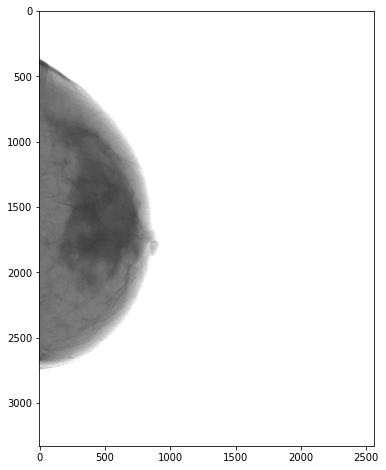

In [78]:
plt.figure(figsize = (8,8))
plt.imshow(img,cmap='gray')

#### Stat Analysis

In [15]:
from scipy import stats
from scipy.stats import shapiro,ranksums

In [98]:
race1 = race1.dropna()
race0 = race0.dropna()

(array([541., 434., 409., 272., 146.,  66.,  28.,  11.,   5.,   2.]),
 array([0.     , 0.07281, 0.14562, 0.21843, 0.29124, 0.36405, 0.43686, 0.50967, 0.58248, 0.65529, 0.7281 ]),
 <a list of 10 Patch objects>)

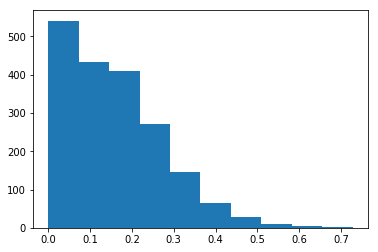

In [15]:
plt.hist(race1.area1)

(array([434., 211., 294., 414., 403., 113.,  39.,   4.,   1.,   1.]),
 array([0.      , 0.055104, 0.110208, 0.165313, 0.220417, 0.275521, 0.330625, 0.385729, 0.440834, 0.495938, 0.551042]),
 <a list of 10 Patch objects>)

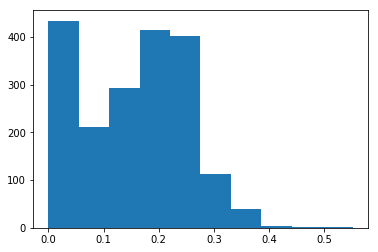

In [17]:
plt.hist(race1.area3)

In [99]:
stats.ranksums(race0.area1.values, race1.area1.values)

RanksumsResult(statistic=4.106475726731749, pvalue=4.017416570201641e-05)

In [100]:
stats.ranksums(race0.area2.values, race1.area2.values)

RanksumsResult(statistic=6.944045597179449, pvalue=3.8102742880108645e-12)

In [101]:
stats.ranksums(race0.area3.values, race1.area3.values)

RanksumsResult(statistic=2.294816515725879, pvalue=0.021743641745393345)

In [102]:
stats.ranksums(race0.area4.values, race1.area4.values)

RanksumsResult(statistic=-2.1737019624963883, pvalue=0.029727525189975536)

In [22]:
stats.ranksums(race0.vertArea1.values, race1.vertArea1.values)

RanksumsResult(statistic=-7.676081094703535, pvalue=1.6402930894491685e-14)

In [23]:
stats.ranksums(race0.vertArea2.values, race1.vertArea2.values)

RanksumsResult(statistic=7.676081094703535, pvalue=1.6402930894491685e-14)

In [24]:
stats.ranksums(race0.area1.values, race0.area2.values)

RanksumsResult(statistic=-4.738159569408911, pvalue=2.1566796294273863e-06)

In [25]:
stats.ranksums(race0.area1.values, race0.area3.values)

RanksumsResult(statistic=1.2623262430588622, pvalue=0.20683141730192445)

In [26]:
stats.ranksums(race0.area1.values, race0.area4.values)

RanksumsResult(statistic=7.839355428915472, pvalue=4.528650163397016e-15)

In [27]:
stats.ranksums(race1.area1.values, race1.area2.values)

RanksumsResult(statistic=-2.8626250646254645, pvalue=0.0042014741162720295)

In [28]:
stats.ranksums(race1.area1.values, race1.area3.values)

RanksumsResult(statistic=-1.9307041903294804, pvalue=0.05351964442978948)

In [29]:
stats.ranksums(race1.area1.values, race1.area4.values)

RanksumsResult(statistic=0.6975220956063847, pvalue=0.4854761164932542)

### GuidedBackProp outputs

In [18]:
guidedBackFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Visualization/GuidedBack_Outputs/'

imageFolder = '/home/santhosr/Documents/Birad/ProcessedData/FullRes/'

In [19]:
fileList = os.listdir(guidedBackFolder)

In [20]:
len(fileList)

15391

In [21]:
df.train.value_counts()

False    12326
True      3091
Name: train, dtype: int64

In [22]:
cleanList = []

for i in range(len(fileList)):
    
    filename = fileList[i].split(".")[0]
    
    if "CC" not in filename:
        continue
    
    if "R" not in filename:
        continue
        
    if filename not in markerDataFileList:
        continue
        
#     try:
#         if df[df.ImageName==filename]['train'][0]==True:
#             continue
#     except:
#         a = 1
# #         print(df[df.ImageName==filename]['train'])
        
    cleanList.append(filename)
        
    

In [23]:
len(cleanList)

3864

### Extracting GuidedBackprop from selected inputs

In [24]:
outList = []

for i in range(len(cleanList)):
    
    filename = cleanList[i]
    
    try:
        grad = pickle.load(open(guidedBackFolder + filename+'.p','rb'))
        
        
        img = df[df.ImageName==filename]['files'].values[0]
        img = imread(imageFolder+img)
        
        imageHeight = img.shape[0]
        imageWidth = float(markerData[markerData.filename==filename]['imageWidth'])
        mult = round(256/imageWidth,3)
        mult1 = round(256/imageHeight,3)

        mark1 = int(float(markerData[markerData.filename==filename]['marker1'])*mult)
        mark2 = int(float(markerData[markerData.filename==filename]['marker2'])*mult)
        mark3 = int(float(markerData[markerData.filename==filename]['marker3'])*mult)
        mark4 = int(float(markerData[markerData.filename==filename]['marker4'])*mult)
        mark5 = int(float(markerData[markerData.filename==filename]['marker5'])*mult)
        
        vertMark = int(float(markerData[markerData.filename==filename]['vertMidPoint'])*mult1)

        area1 = np.sum(grad[:, mark1:mark2])
        area2 = np.sum(grad[:, mark2:mark3])
        area3 = np.sum(grad[:, mark3:mark4])
        area4 = np.sum(grad[:, mark4:mark5])
        
        vertArea1 = np.sum(grad[:vertMark, :])
        vertArea2 = np.sum(grad[vertMark:, :])

        bandGap = mark2 - mark1

        totalArea = np.sum(grad)

        outList.append([filename, area1,area2,area3,area4, vertArea1, vertArea2, bandGap, totalArea])
    
    except:
        pass
    
    

In [25]:
outList = pd.DataFrame(outList)

In [26]:
outList.columns = ['filename','area1','area2','area3','area4', 'vertArea1', 'vertArea2','bandGap','totalArea']


In [27]:
outList.head()

,filename,area1,area2,area3,area4,vertArea1,vertArea2,bandGap,totalArea
0,3673890_R_CC_1,1797.597290,1770.078125,1860.002930,3272.370605,9751.776367,12407.451172,29,22159.228516
1,76434528_R_CC_1,6545.959473,7185.452148,5502.702148,3715.930176,16400.292969,9483.934570,34,25884.226562
2,75954889_R_CC_1,4069.529053,2910.148926,1149.327271,1000.922852,5628.728516,8429.015625,38,14057.744141
3,76054106_R_CC_1,1260.093140,1589.450317,2112.616211,2468.351562,11090.153320,9453.588867,23,20543.740234
4,5221404_R_CC_1,5023.576172,5298.559082,4301.443848,2808.479492,14071.490234,7915.701660,24,21987.193359


In [28]:
outList.patientID = outList.filename.apply(lambda x : x.split("_")[0])

outList.area1 = outList.area1/outList.totalArea
outList.area2 = outList.area2/outList.totalArea
outList.area3 = outList.area3/outList.totalArea
outList.area4 = outList.area4/outList.totalArea

outList.vertArea1 = outList.vertArea1/outList.totalArea
outList.vertArea2 = outList.vertArea2/outList.totalArea





In [29]:
outList = pd.merge(outList, df[['ImageName','Race']],left_on='filename',right_on='ImageName')

In [30]:
outList.head()

,filename,area1,area2,area3,area4,vertArea1,vertArea2,bandGap,totalArea,ImageName,Race
0,3673890_R_CC_1,0.081122,0.079880,0.083938,0.147675,0.440077,0.559923,29,22159.228516,3673890_R_CC_1,1
1,76434528_R_CC_1,0.252894,0.277600,0.212589,0.143560,0.633602,0.366398,34,25884.226562,76434528_R_CC_1,0
2,75954889_R_CC_1,0.289487,0.207014,0.081758,0.071201,0.400401,0.599599,38,14057.744141,75954889_R_CC_1,1
3,76054106_R_CC_1,0.061337,0.077369,0.102835,0.120151,0.539831,0.460169,23,20543.740234,76054106_R_CC_1,1
4,5221404_R_CC_1,0.228477,0.240984,0.195634,0.127733,0.639986,0.360014,24,21987.193359,5221404_R_CC_1,0


In [31]:
outList.to_csv('GuidedBackProp_finalOutput.csv',index=False, index_label = False)

# Testing

In [87]:
outList = pd.read_csv('GuidedBackProp_finalOutput.csv')

In [88]:
outList.head()

,filename,area1,area2,area3,area4,vertArea1,vertArea2,bandGap,totalArea,ImageName,Race
0,3673890_R_CC_1,0.081122,0.079880,0.083938,0.147675,0.440077,0.559923,29,22159.228516,3673890_R_CC_1,1
1,76434528_R_CC_1,0.252894,0.277600,0.212589,0.143560,0.633602,0.366398,34,25884.226562,76434528_R_CC_1,0
2,75954889_R_CC_1,0.289487,0.207014,0.081758,0.071201,0.400401,0.599599,38,14057.744141,75954889_R_CC_1,1
3,76054106_R_CC_1,0.061337,0.077369,0.102835,0.120151,0.539831,0.460169,23,20543.740234,76054106_R_CC_1,1
4,5221404_R_CC_1,0.228477,0.240984,0.195634,0.127733,0.639986,0.360014,24,21987.193359,5221404_R_CC_1,0


In [89]:
race0 = outList[outList.Race==0]
race1 = outList[outList.Race==1]



In [112]:
race0.mean().reset_index()

,index,0
0,area1,0.182848
1,area2,0.193773
2,area3,0.168983
3,area4,0.145054
4,vertArea1,0.485422
5,vertArea2,0.514578
6,bandGap,38.223819
7,totalArea,25237.883898
8,Race,0.000000


In [113]:
race1.mean().reset_index()

,index,0
0,area1,0.148802
1,area2,0.156147
2,area3,0.150476
3,area4,0.140735
4,vertArea1,0.496259
5,vertArea2,0.503741
6,bandGap,32.738245
7,totalArea,23513.298526
8,Race,1.000000


In [90]:
race1 = race1.dropna()
race0 = race0.dropna()

##### Across Races

In [91]:
stats.ranksums(race0.area1.values, race1.area1.values)

RanksumsResult(statistic=11.496050756640878, pvalue=1.3809032351458083e-30)

In [92]:
stats.ranksums(race0.area2.values, race1.area2.values)

RanksumsResult(statistic=12.974300125739907, pvalue=1.7115252614696461e-38)

In [93]:
stats.ranksums(race0.area3.values, race1.area3.values)

RanksumsResult(statistic=7.94312776542786, pvalue=1.9714568955732724e-15)

In [94]:
stats.ranksums(race0.area4.values, race1.area4.values)

RanksumsResult(statistic=1.8858410875104734, pvalue=0.05931637228336264)

In [60]:
stats.ranksums(race0.vertArea1.values, race1.vertArea1.values)

RanksumsResult(statistic=-7.676081094703535, pvalue=1.6402930894491685e-14)

##### Within Race

In [43]:
stats.ranksums(race0.area1.values, race0.area2.values)[1]

2.1566796294273863e-06

In [44]:
stats.ranksums(race0.area1.values, race0.area3.values)[1]

0.20683141730192445

In [45]:
stats.ranksums(race0.area1.values, race0.area4.values)[1]

4.528650163397016e-15

In [46]:
stats.ranksums(race0.area2.values, race0.area3.values)[1]

5.943267333753636e-13

In [47]:
stats.ranksums(race0.area2.values, race0.area4.values)[1]

7.718564114493577e-30

In [48]:
stats.ranksums(race0.area3.values, race0.area4.values)[1]

8.96517847174985e-17

In [49]:
stats.ranksums(race1.area1.values, race1.area2.values)[1]

0.0042014741162720295

In [50]:
stats.ranksums(race1.area1.values, race1.area3.values)[1]

0.05351964442978948

In [51]:
stats.ranksums(race1.area1.values, race1.area4.values)[1]

0.4854761164932542

In [52]:
stats.ranksums(race1.area2.values, race1.area3.values)[1]

0.15024859362935442

In [53]:
stats.ranksums(race1.area2.values, race1.area4.values)[1]

3.0218982832553113e-05

In [54]:
stats.ranksums(race1.area3.values, race1.area4.values)[1]

0.00310387168061006

With just the valid data

In [96]:
race0.mean().reset_index()

,index,0
0,area1,0.196057
1,area2,0.211874
2,area3,0.179653
3,area4,0.145786
4,vertArea1,0.495530
5,vertArea2,0.504470
6,bandGap,37.954606
7,totalArea,26475.577114
8,Race,0.000000


In [97]:
race1.mean().reset_index()

,index,0
0,area1,0.151298
1,area2,0.166611
2,area3,0.163277
3,area4,0.151495
4,vertArea1,0.481080
5,vertArea2,0.518920
6,bandGap,32.952120
7,totalArea,24439.231262
8,Race,1.000000
